# Failure prediction of FPSO's equipment
**Author:** Matheus Bom

**E-mail:** matbom95@gmail.com

**GitHub:** https://github.com/MatBom

**LinkedIn:** https://www.linkedin.com/in/matheus-bom

# About the business case

This business case is based on a real-world scenario involving the operation of an FPSO (Floating Production, Storage, and Offloading) vessel. The focus is on identifying patterns that may indicate an imminent failure in one of the onboard machines. FPSOs rely on a wide array of sensors and instrumentation to monitor and control equipment performance across various configurations and time periods. The challenge consists of analyzing historical time series data from one specific piece of equipment in different operating cycles, with the objective of identifying sensor behaviors and parameters that may serve as early warning signs of equipment failure.

The dataset provided contains anonymized operational records collected over time from this equipment. These records include multiple sensor readings that capture key physical and operational parameters, offering a foundation for developing data-driven insights into machine reliability and predictive maintenance opportunities.

# Exploratory Data analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('Test O_G_Equipment_Data.xlsx')

## Data Dictionary
**Cycle:** Sequential order of measurement cycles (appropriate for time-series analysis).

**Preset:** Specific equipment configuration, Preset 1 has 3 settings, while Preset 2 has 8.

**Temperature:** Temperature recorded in the equipment.

**Vibrations (X, Y, Z):** Vibrations along the machine's axes, with 3 degrees of freedom.

**Frequency:** Operating frequency of the machine (indicates how fast the equipment is running during each cycle).

**Fail:** Target variable indicating whether the machine has failed.

In [2]:
df.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Temperature  800 non-null    float64
 4   Pressure     800 non-null    float64
 5   VibrationX   800 non-null    float64
 6   VibrationY   800 non-null    float64
 7   VibrationZ   800 non-null    float64
 8   Frequency    800 non-null    float64
 9   Fail         800 non-null    bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 57.2 KB


The dataset is complete, with no missing values, ideal to start the exploratory analysis.

## 1. How many times the equipment has failed

First, it is necessary to observe how failures behave to check if there are any insights to be gained from the data or any business complexity (such as the machine failing consecutively for several cycles).

Number of times the equipment has failed: 66 out of 800 cycles (failure rate of 8.25%)


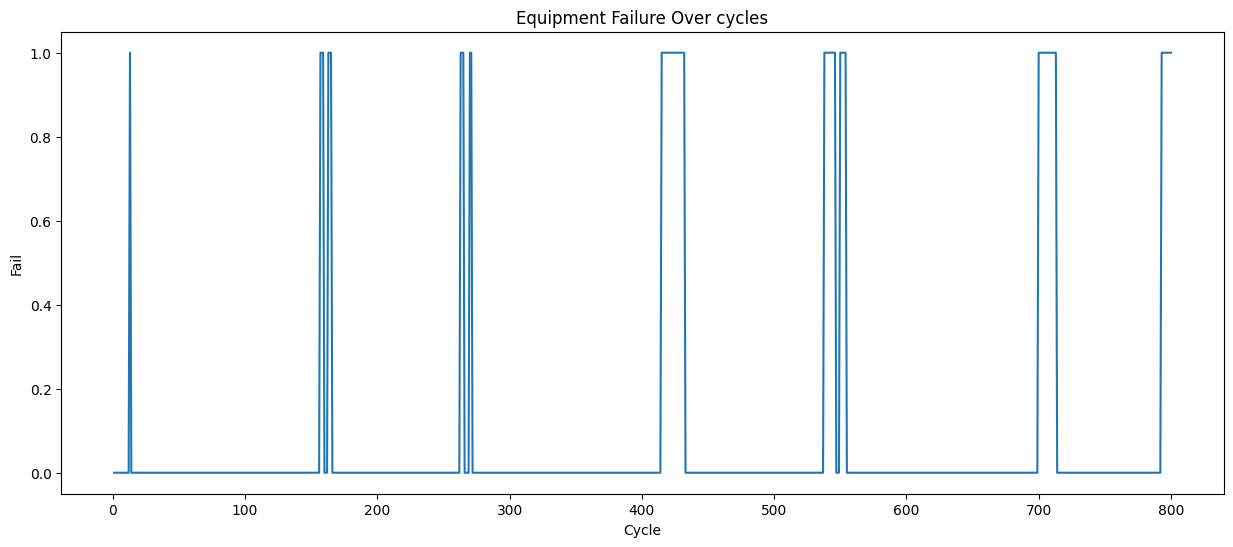

In [4]:
print(f'Number of times the equipment has failed: {df["Fail"].sum()} out of {df["Cycle"].count()} cycles (failure rate of {df["Fail"].mean() * 100:.2f}%)')

plt.figure(figsize=(15, 6))
sns.lineplot(data = df, x = 'Cycle', y = 'Fail')
plt.title('Equipment Failure Over cycles')
plt.show()

The machine appears to have well-spaced failures, but it is observed that not only are there sequential cycles of failures, there are also moments when a failure occurs quickly after the previous failure has recovered. This behavior may require future feature engineering.

Total failures in window: 18
Failure window starts at cycle 415 and ends at cycle 432


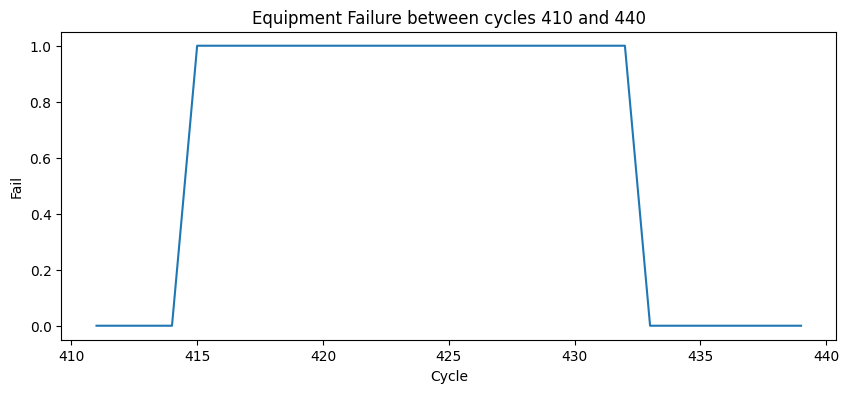

In [5]:
# Filter the window where failures occurred between cycles 410 and 440
window_df = df[(df['Cycle'] > 410) & (df['Cycle'] < 440) & (df['Fail'])]

# Show summary statistics for the failure window
print(f'Total failures in window: {window_df.shape[0]}')
print(f'Failure window starts at cycle {window_df["Cycle"].min()} and ends at cycle {window_df["Cycle"].max()}')


plt.figure(figsize=(10, 4))
sns.lineplot(data = df[(df['Cycle'] > 410) & (df['Cycle'] < 440)], x = 'Cycle', y = 'Fail')
plt.title('Equipment Failure between cycles 410 and 440')
plt.show()

Overall, **the equipment failed 66 out of 800 cycles**, with a failure rate of 8.25%. A closer look at the biggest failure window tell us that **a failure state can last up to 18 cycles**.

A strategy I’ll use is to group together failure cycles that happen close to each other and treat them as a **single failure sequence**. This is because, in real-world scenarios, when industrial equipment fails, the maintenance team might restart the machine multiple times while running tests or making adjustments, but the problem usually continues until it’s fully resolved.

In [6]:
def combine_fails(df: pd.DataFrame, lag: int, label_col: str = 'label') -> pd.DataFrame:
    """
    Propagates failure labels (1) forward and backward within a range defined by `lag`.
    This "merges" failures that are close to each other into a single continuous sequence of 1s.

    Parameters:
    - df: The DataFrame being used.
    - lag: Maximum number of zeros allowed between failures for them to be considered part of the same failure.
    - label_col: Name of the column with the binary labels.

    Returns:
    - DataFrame with the modified label column.
    """

    df = df.copy()
    labels = df[label_col].values
    n = len(labels)
    output = labels.copy()

    i = 0
    while i < n:
        if labels[i] == 1:
            start = i
            end = i
             # Extend the failure window as long as there are at most `lag` zeros between 1s
            while end + 1 < n:
                zeros = 0
                j = end + 1
                 # Count how many zeros appear between consecutive 1s
                while j < n and labels[j] == 0 and zeros < lag:
                    zeros += 1
                    j += 1
                # If another failure (1) is found within the allowed gap, extend the window
                if j < n and labels[j] == 1 and zeros <= lag:
                    end = j
                else:
                    break
            # Set all values in the combined failure window to 1
            output[start:end+1] = 1
            i = end + 1
        else:
            i += 1

    df[label_col] = output
    return df

Number of times the equipment has failed: 76 out of 800 cycles (failure rate of 9.50%)


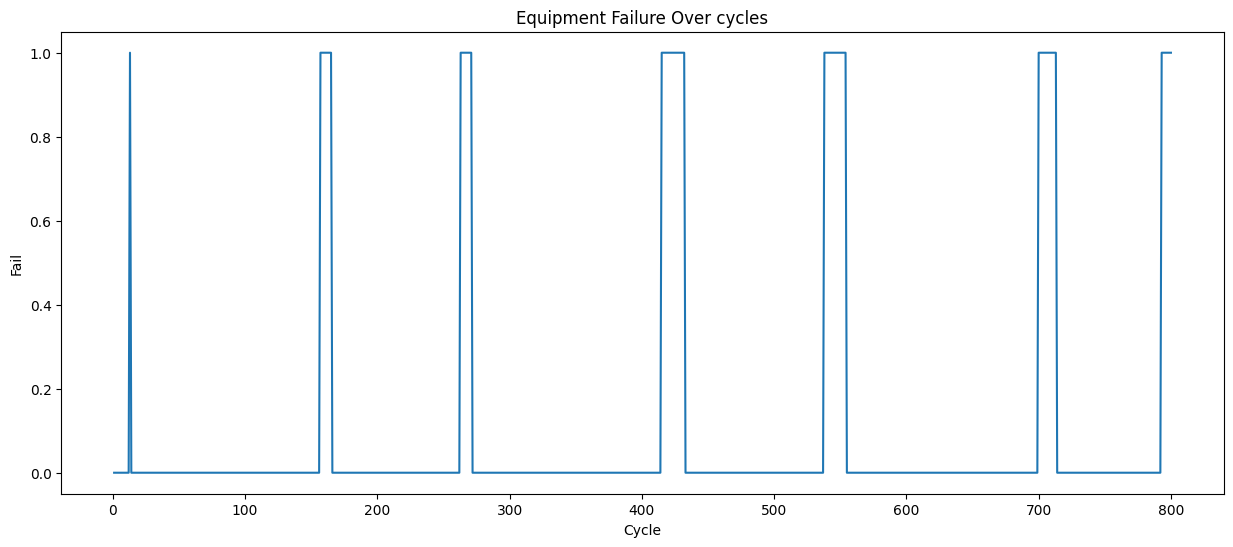

In [7]:
df = combine_fails(df, lag=30, label_col='Fail')

print(f'Number of times the equipment has failed: {df["Fail"].sum()} out of {df["Cycle"].count()} cycles (failure rate of {df["Fail"].mean() * 100:.2f}%)')

plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='Cycle', y='Fail')
plt.title('Equipment Failure Over cycles')
plt.show()

Now, with the aggregated failure windows, I'm considering that **the equipment failed during 76 out of 800 cycles**, resulting in a failure rate of 9.50%.

## 2. Equipment failures by setup configurations

I will check whether all configuration combinations are being used uniformly, or if there is an unbalanced use of the configurations. Additionally, I will observe the equipment failure proportion for each configuration pair to identify any strong association between configuration and failure.

In [8]:
# Just checking the available presets
print(f'Available settings in preset_1: {df["Preset_1"].sort_values().unique()}')
print(f'Available settings in preset_2: {df["Preset_2"].sort_values().unique()}')

Available settings in preset_1: [1 2 3]
Available settings in preset_2: [1 2 3 4 5 6 7 8]


I will be treating preset as **a categorical variable**. In order to measure association between preset and failure, it will be used Cramér's V, a measure based on Pearson's chi-square test.

In [9]:
from scipy.stats import chi2_contingency

confusion_matrix = pd.crosstab(df['Preset_1'], df['Fail'])
chi2 = chi2_contingency(confusion_matrix)[0]
n = confusion_matrix.sum().sum()
r, k = confusion_matrix.shape
print(f'The association between preset 1 and failure is: {np.sqrt(chi2 / (n * (min(r, k) - 1))):.3f}')

# Checking if Preset 1 is being used uniformly and has a strong association with failure
grouped = df.groupby(['Preset_1'])
result = grouped['Fail'].agg(
    count='size',
    fail_count = lambda x: (x).sum(),
    fail_proportion=lambda x: (x).mean()
).reset_index().sort_values('fail_proportion', ascending=False)
print(result)

The association between preset 1 and failure is: 0.054
   Preset_1  count  fail_count  fail_proportion
0         1    264          31         0.117424
1         2    281          24         0.085409
2         3    255          21         0.082353


The association of 0.051 implies in a **weak association** between Preset 1 and fail

In [10]:
confusion_matrix = pd.crosstab(df['Preset_2'], df['Fail'])
chi2 = chi2_contingency(confusion_matrix)[0]
n = confusion_matrix.sum().sum()
r, k = confusion_matrix.shape
print(f'The association between preset 2 and failure is: {np.sqrt(chi2 / (n * (min(r, k) - 1))):.3f}')

# Checking if Preset 2 is being used uniformly and has a strong association with failure
grouped = df.groupby(['Preset_2'])
result = grouped['Fail'].agg(
    count='size',
    fail_count = lambda x: (x).sum(),
    fail_proportion=lambda x: (x).mean()
).reset_index().sort_values('fail_proportion', ascending=False)
result

The association between preset 2 and failure is: 0.098


,Preset_2,count,fail_count,fail_proportion
4,5,100,14,0.140000
0,1,95,11,0.115789
1,2,101,11,0.108911
6,7,109,11,0.100917
2,3,101,9,0.089109
5,6,101,9,0.089109
7,8,100,8,0.080000
3,4,93,3,0.032258


The association of 0.096 for preset 2 is slightly stronger, but overall still a **weak association**.

In [11]:
# Combining both presets into one single feature
df['Preset'] = df['Preset_1'].astype(str) + '-' + df['Preset_2'].astype(str)

confusion_matrix = pd.crosstab(df['Preset'], df['Fail'])
chi2 = chi2_contingency(confusion_matrix)[0]
n = confusion_matrix.sum().sum()
r, k = confusion_matrix.shape
print(f'The association between both presets and failure is: {np.sqrt(chi2 / (n * (min(r, k) - 1))):.3f}')

# Checking whether both Presets are being used uniformly and if there is a strong correlation with failure
grouped = df.groupby(['Preset'])
result = grouped['Fail'].agg(
    count='size',
    fail_count = lambda x: (x).sum(),
    fail_proportion=lambda x: (x).mean()
).reset_index().sort_values('fail_proportion', ascending=False)
result

The association between both presets and failure is: 0.127


,Preset,count,fail_count,fail_proportion
4,1-5,31,6,0.193548
20,3-5,29,4,0.137931
8,2-1,30,4,0.133333
1,1-2,38,5,0.131579
6,1-7,38,5,0.131579
0,1-1,34,4,0.117647
15,2-8,37,4,0.108108
17,3-2,29,3,0.103448
21,3-6,30,3,0.100000
12,2-5,40,4,0.100000


C:\Users\matbo\AppData\Local\Temp\ipykernel_20108\1071470401.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


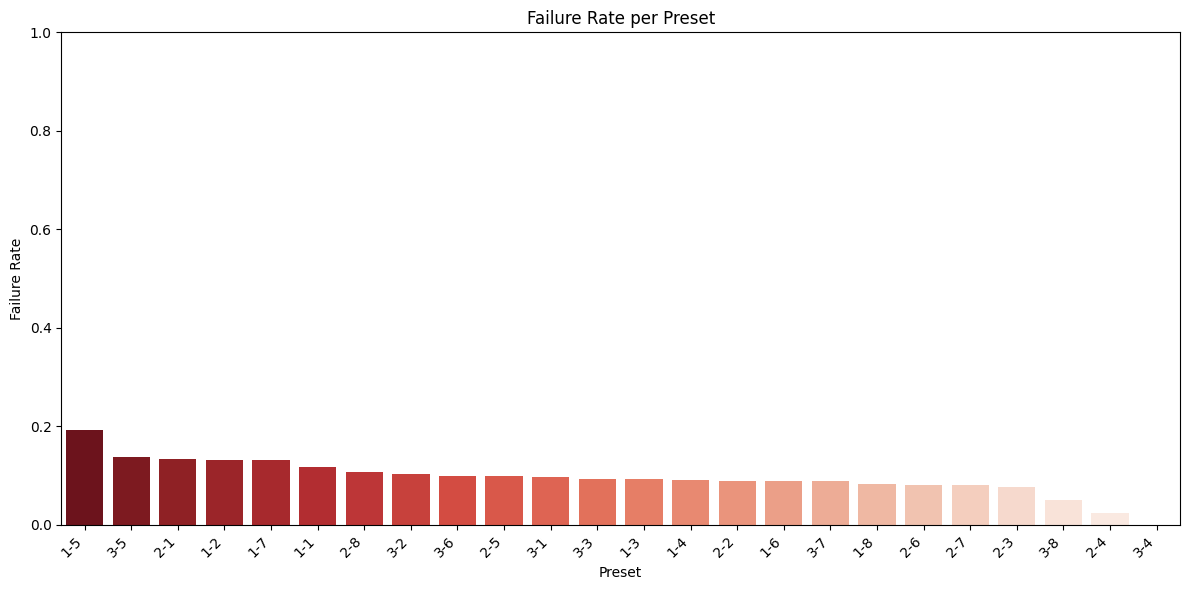

In [12]:
# Failure rate per preset barplot
result = result.sort_values('fail_proportion', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=result,
    x='Preset',
    y='fail_proportion',
    palette='Reds_r'
)

plt.title('Failure Rate per Preset')
plt.ylabel('Failure Rate')
plt.xlabel('Preset')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

The combination of presets 1 and 2 resulted in **a weak association of 0.138**, altough it was a little bit stronger than the association of presets 1 and 2 watched separately. Which means that while neither preset alone shows a strong link to failure, certain combinations may slightly increase the likelihood of failure. This suggests that **presets may have a predictive power**, but it remains limited.

## 3. Equipment failures by readings

The goal here is to confirm whether failures occur when observing high readings from features, and also whether failures stop occurring when only one high reading is made while the others remain at normal levels.

Also, the vibration reading was provided as a decomposed vector, so its magnitude (module) can serve as a useful feature for the model. However, the magnitude only represents the intensity of the vibration, without any directional information. It is still important to investigate whether failures can be caused by vibration along a specific axis, which could indicate a potential issue with the equipment's strength or design.

In [13]:
df["Vibration"] = np.sqrt(df["VibrationX"]**2 + df["VibrationY"]**2 + df["VibrationZ"]**2)

<Axes: title={'center': 'Vibration (module)'}, xlabel='Vibration', ylabel='Count'>

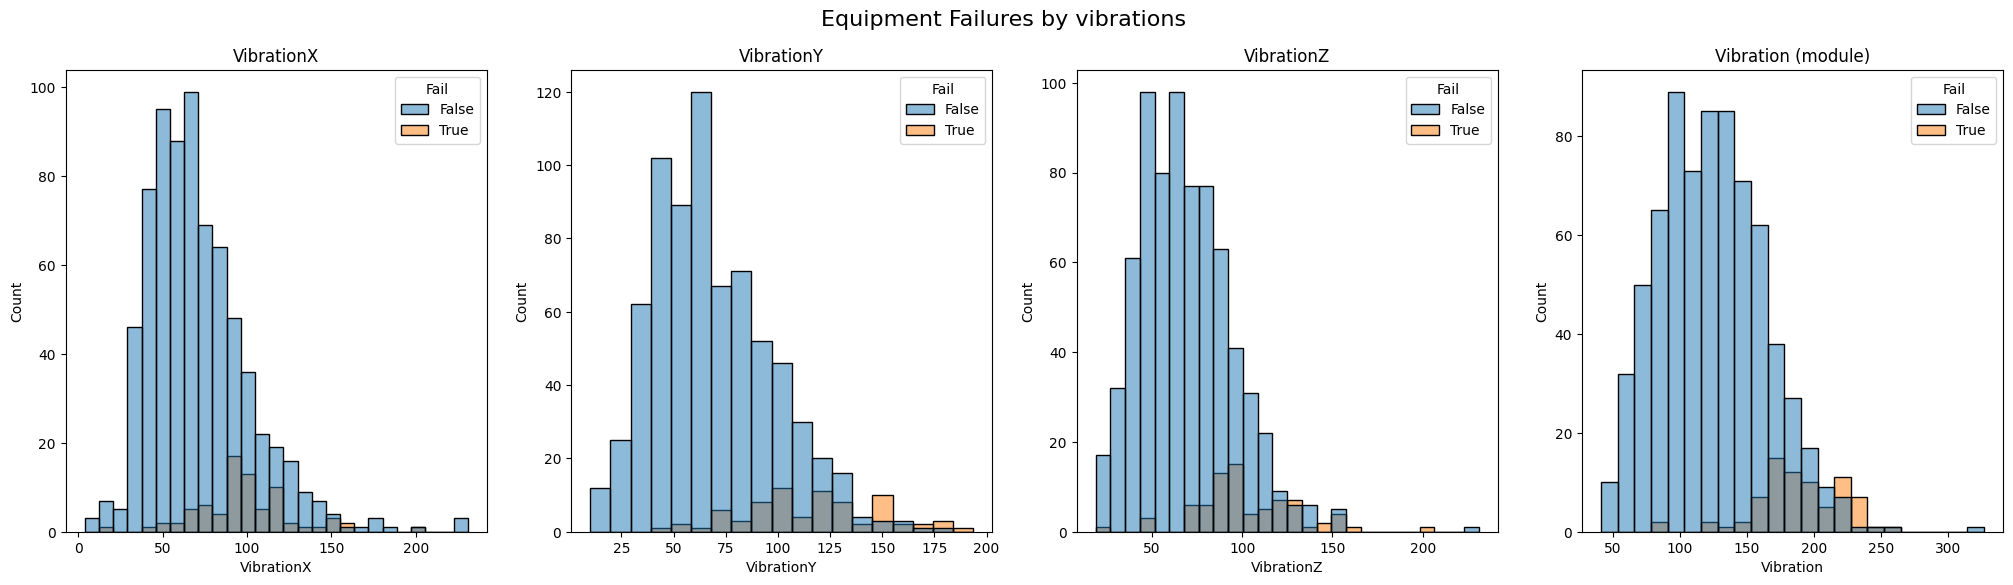

In [14]:
figure, axes = plt.subplots(1, 4,figsize=(25, 6))
figure.suptitle('Equipment Failures by vibrations', fontsize=16)
axes[0].set_title('VibrationX')
axes[1].set_title('VibrationY')
axes[2].set_title('VibrationZ')
axes[3].set_title('Vibration (module)')

sns.histplot(data = df, x = 'VibrationX', hue = 'Fail', ax = axes[0])
sns.histplot(data = df, x = 'VibrationY', hue = 'Fail', ax = axes[1])
sns.histplot(data = df, x = 'VibrationZ', hue = 'Fail', ax = axes[2])
sns.histplot(data = df, x = 'Vibration', hue = 'Fail', ax = axes[3])

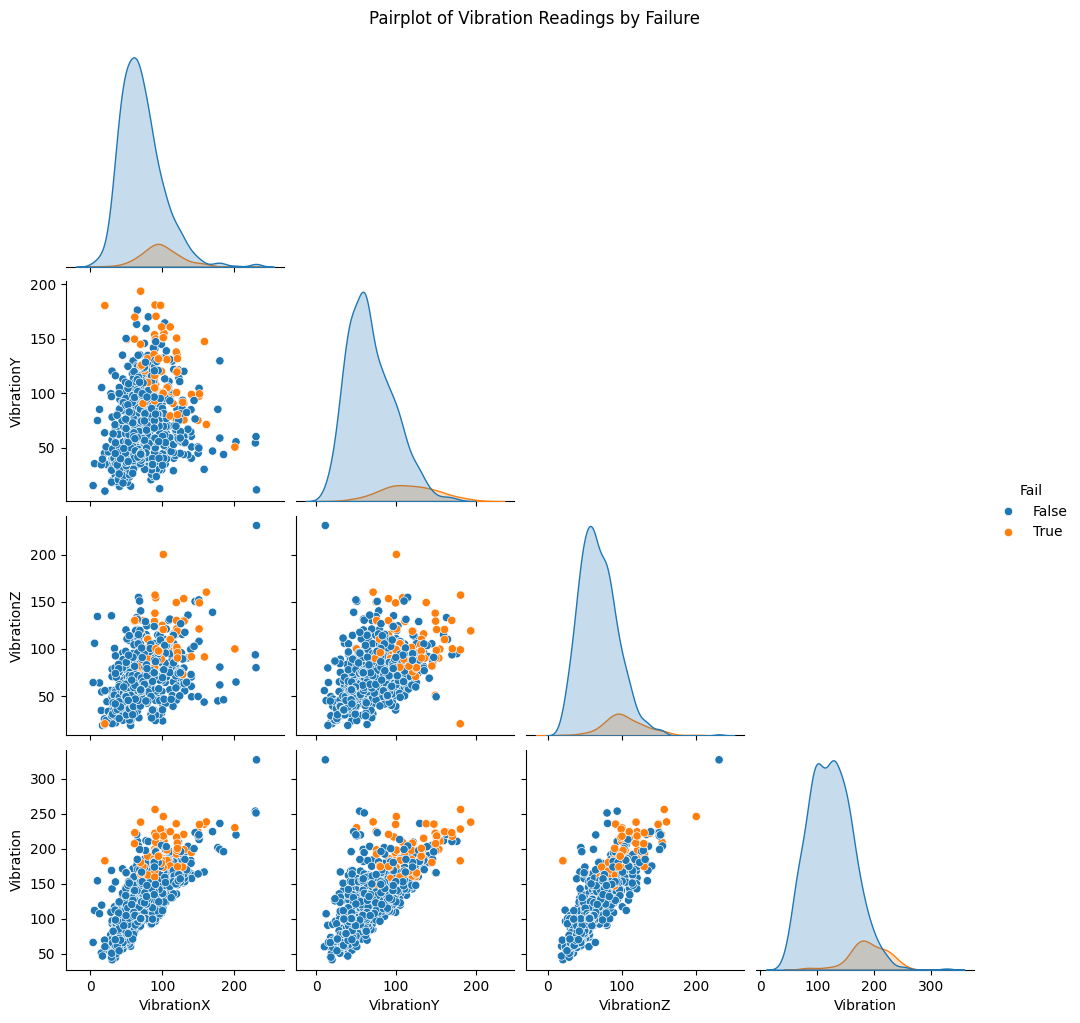

In [15]:
sns.pairplot(df, vars=['VibrationX', 'VibrationY', 'VibrationZ', 'Vibration'], hue='Fail', corner=True)
plt.suptitle("Pairplot of Vibration Readings by Failure", y=1.02)
plt.show()

Even with a single feature indicating the total vibration intensity of the equipment, **it may be still relevant to look at the vibration along the Y axis**, which shows a behavior more prone to failures than the other axes. In order to dedice whether the three vibration axes are being kept as features, I'll check if there is multicollinearity between vibration and each of its axes.

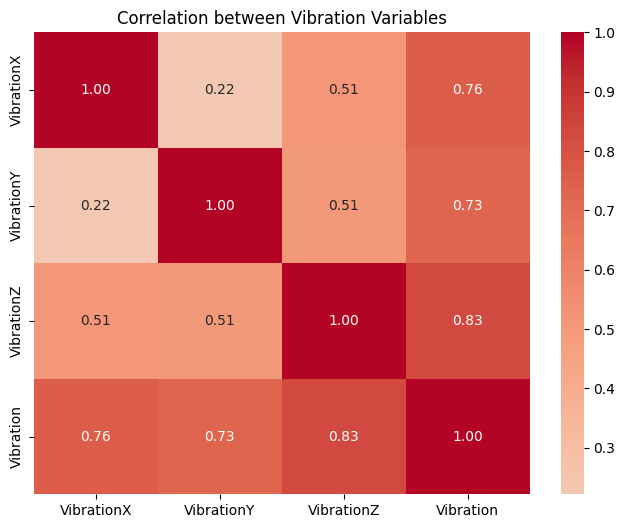

In [16]:
# Picking the columns related to vibration and calculating the correlation matrix
cols_vibration = ['VibrationX', 'VibrationY', 'VibrationZ', 'Vibration']
corr = df[cols_vibration].corr(numeric_only=True)

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation between Vibration Variables')
plt.show()


The strongest correlations are exactly between Vibration and each axis. Therefore, this creates a favorable scenario for **removing the vibration axes from the model** to avoid multicollinearity.

Now, looking at the other readings, the objective is to check if any reading has good enough predictive power or if a new feature is needed.

<Axes: title={'center': 'Vibration'}, xlabel='Vibration', ylabel='Count'>

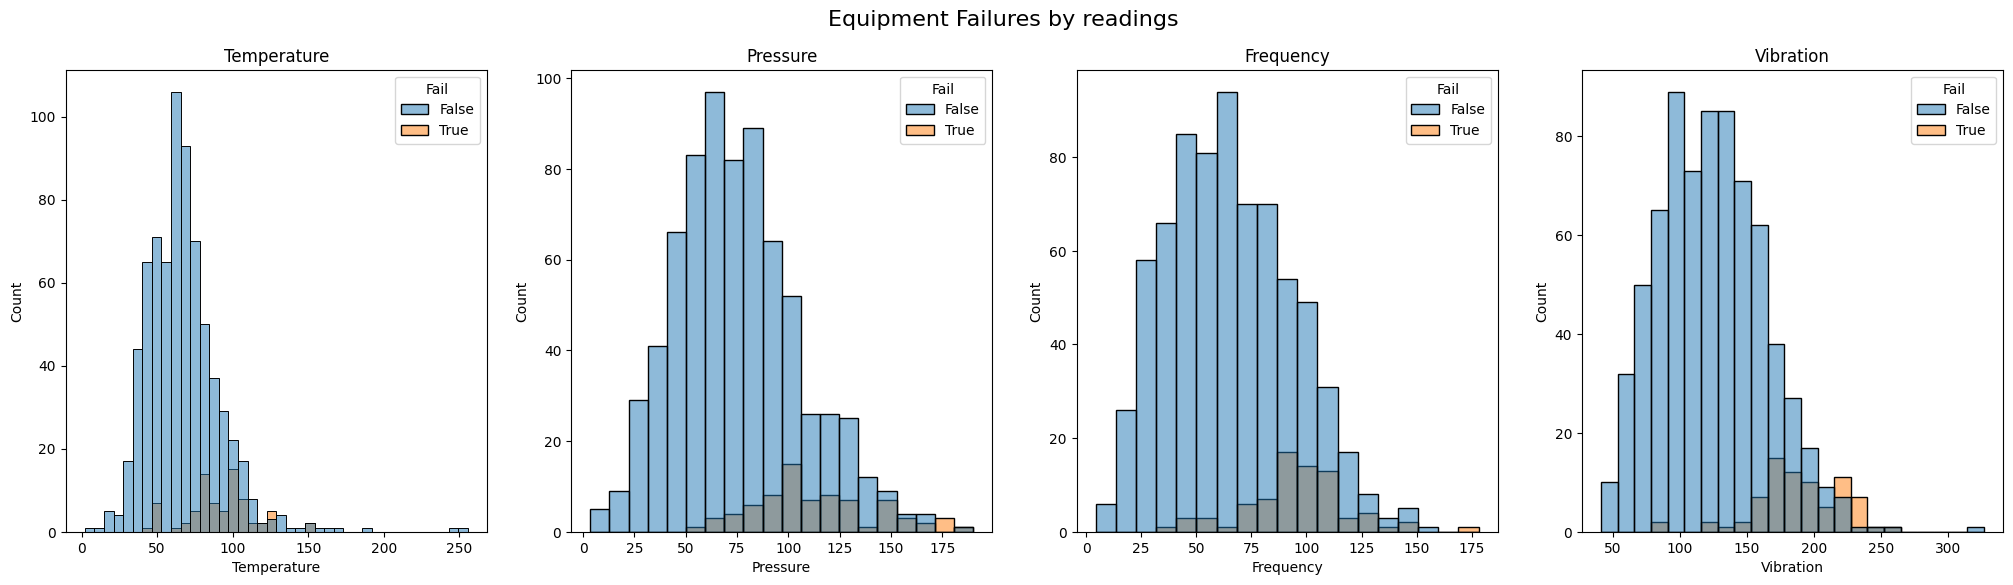

In [17]:
figure, axes = plt.subplots(1, 4,figsize=(25, 6))
figure.suptitle('Equipment Failures by readings', fontsize=16)
axes[0].set_title('Temperature')
axes[1].set_title('Pressure')
axes[2].set_title('Frequency')
axes[3].set_title('Vibration')

sns.histplot(data = df, x = 'Temperature', hue = 'Fail', ax = axes[0])
sns.histplot(data = df, x = 'Pressure', hue = 'Fail', ax = axes[1])
sns.histplot(data = df, x = 'Frequency', hue = 'Fail', ax = axes[2])
sns.histplot(data = df, x = 'Vibration', hue = 'Fail', ax = axes[3])

Looking at the individual histograms of temperature, pressure, frequency and vibration, it's possible to observe that higher values are more likely to result in a failure. But there are high readings in a non-failure state.

Only vibrations presents higher values with more failure concentration. Which may point to **a better predictive power than other variables.**

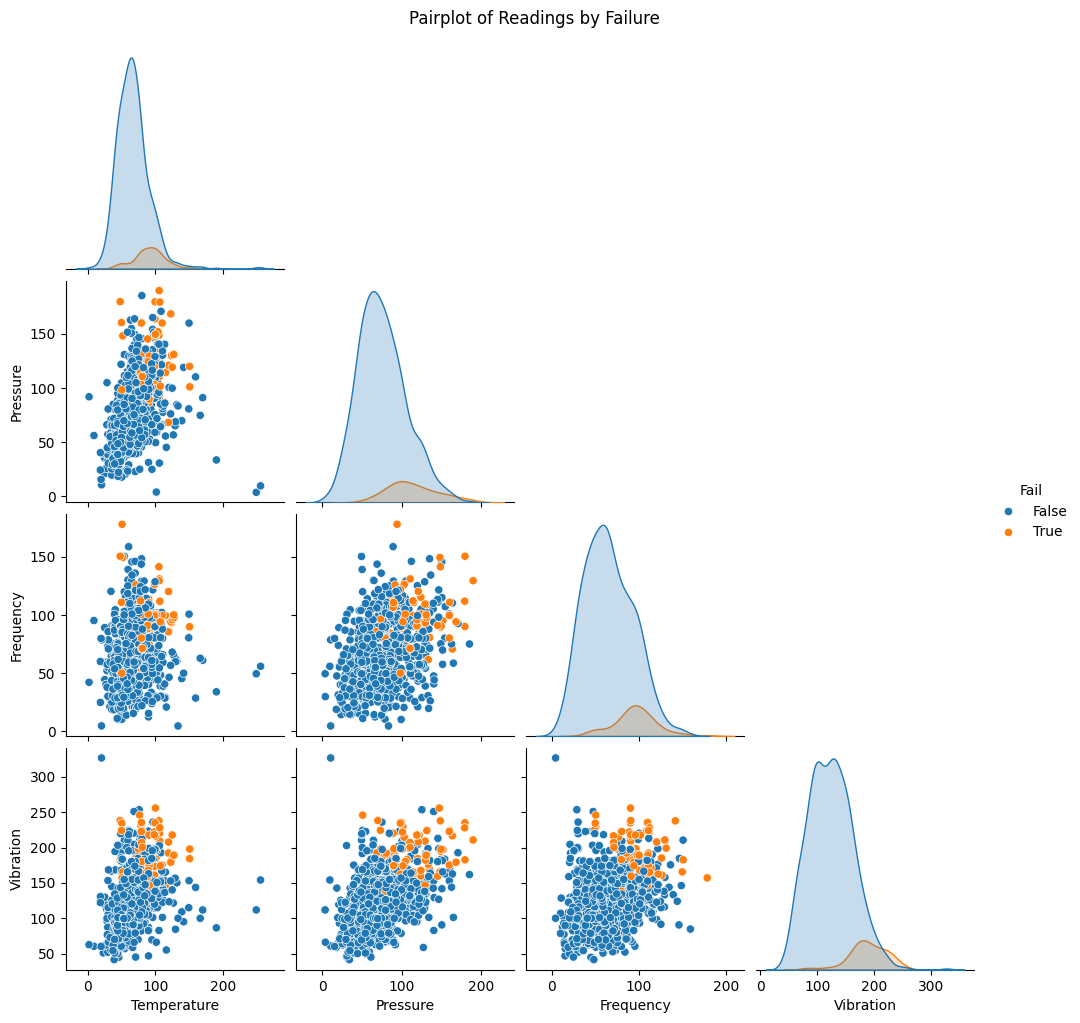

In [18]:
sns.pairplot(df, vars=['Temperature', 'Pressure', 'Frequency', 'Vibration'], hue='Fail', corner=True)
plt.suptitle("Pairplot of Readings by Failure", y=1.02)
plt.show()


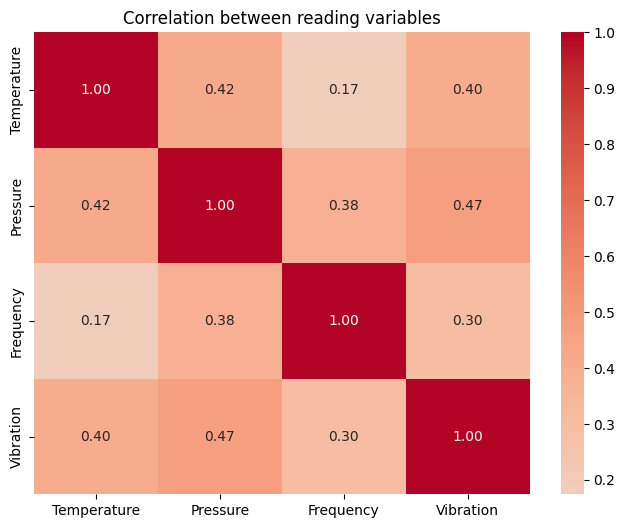

In [19]:
# Picking the columns related to readings and calculating the correlation matrix
cols_vibration = ['Temperature', 'Pressure', 'Frequency', 'Vibration']
corr = df[cols_vibration].corr(numeric_only=True)

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation between reading variables')
plt.show()


The behavior of the features as a group tends to concentrate at high values, but the concern is that failure readings are not isolated from readings where there is no failure. Only with vibration and frequency is it possible to observe a "cleaner" separation, although there are still non-failure readings in the same region.

The correlation between all the readings shows a low to medium level of correlation, pointing that each reading has it's own value when explaining the target feature.

Now that we took a look into the readings, I would like to bring a preset analysis back, to check if a preset is capable of control other variables and let the machine to operate at higher readings of temperature, pressure or frequency. Maybe one specific preset makes the equipment heat more, or maybe have a higher frequency to boost productivity and that could lead to a failure.

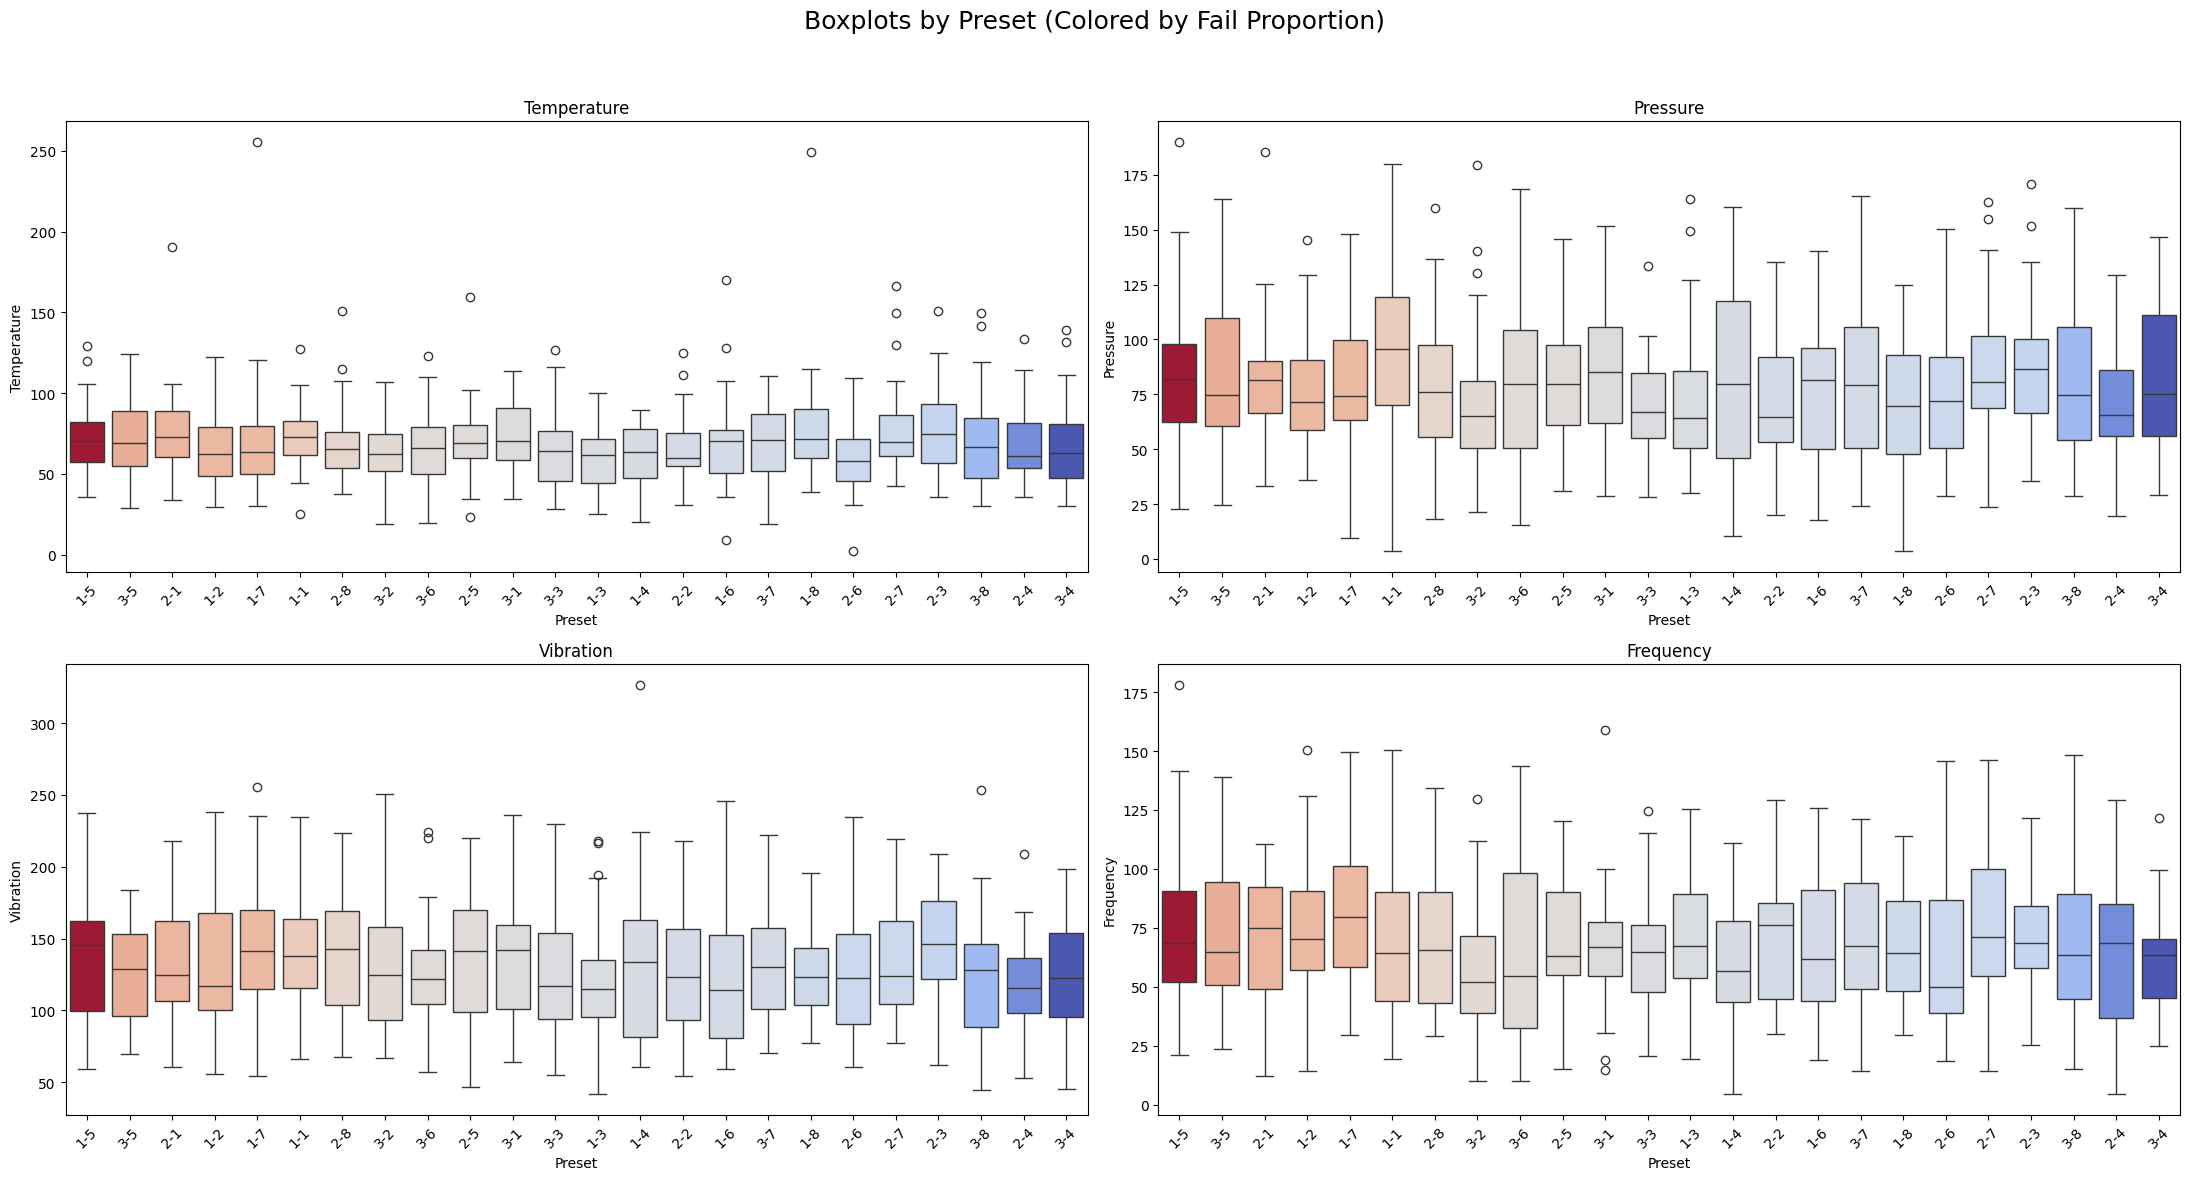

In [20]:
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import warnings
warnings.filterwarnings('ignore')

# Normalize the fail proportion for coloring
norm = Normalize(vmin=result['fail_proportion'].min(), vmax=result['fail_proportion'].max())
cmap = get_cmap('coolwarm')
preset_color_map = {
    row['Preset']: cmap(norm(row['fail_proportion'])) for _, row in result.iterrows()
}

# Plotting boxplots for each variable colored by preset's fail proportion
fig, axes = plt.subplots(2, 2, figsize=(22, 12))
fig.suptitle("Boxplots by Preset (Colored by Fail Proportion)", fontsize=18)

variables = ['Temperature', 'Pressure', 'Vibration', 'Frequency']
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

for var, (i, j) in zip(variables, positions):
    ax = axes[i][j]
    sns.boxplot(
        data=df,
        x='Preset',
        y=var,
        ax=ax,
        palette=preset_color_map,
        order=result['Preset']  # ensures consistent order
    )
    ax.set_title(f"{var}")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The presets are colored with the failure rate previously calculated. These presets with higher failure rate doesn't appear to have a different behavior from other presets, neither more outliers, neither higher median, which indicates that the presets have their own predictive characteristics separate from the readings.

I will use Eta² as a last resort, a statistic that quantifies how much of the total variability in a dependent variable is explained by an independent categorical variable.

In [21]:
def eta_squared(df, cat_col, cont_col):
    """
    Calculates how much of the total variability of a dependent variable is explained by an independent categorical variable.

    Parameters:
    - df: The DataFrame being used.
    - cat_col: categorical column.
    - cont_col: continuous column .

    Returns:
    - Float with the corresponding association.
    """
    groups = df.groupby(cat_col)[cont_col]
    means = groups.mean()
    counts = groups.count()
    overall_mean = df[cont_col].mean()

    ss_between = sum(counts * (means - overall_mean)**2)
    ss_total = sum((df[cont_col] - overall_mean)**2)

    return ss_between / ss_total

# Aplicar para cada variável contínua
for col in ['Temperature', 'Pressure', 'Vibration', 'Frequency']:
    eta2 = eta_squared(df, 'Preset', col)
    print(f"Eta² between Preset and {col}: {eta2:.3f}")

Eta² between Preset and Temperature: 0.039
Eta² between Preset and Pressure: 0.034
Eta² between Preset and Vibration: 0.033
Eta² between Preset and Frequency: 0.025


For independent features, Eta² is expected to be close to zero, as the results above suggest. This is a strong indicative that **preset has no meaningful explanatory power over the other sensor readings.**

## Predictive Maintenance

In order to train a model capable of predicting a failure before it actually occurs, it is necessary to create new features that capture patterns leading up to the failure event. Instead of simply detecting when the equipment is already in failure state, the goal is to identify early warning signs.

To support this, I will build a new set of shifted target features, where the failure signal is moved *n* cycles earlier, labeling data points that happened prior to the failure. For example, if a failure happens at cycle 100, shifting the failure label back by 5 cycles means cycles 95 will be treated as "pre-failure", allowing the model to learn from data that precedes the issue.

To calculate the value of *n*, I'll do a brief time series analysis using two functions called Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF).

Below I'll prepare what would be a set of new target features. But before shifting the failure *n* cycles, it's important to know how many cycles are statiscally relevant for each reading when plotting the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF), since cycle is a time-series.

- ACF measures how correlated a time series is with its own past values over different lags (cycles). It is like asking: "If the vibration is high in this cycle, how similar was it yesterday, 2 days ago and 3 days ago, so on...?"
- PACF measures the direct correlation between a time series and its lagged versions, removing the influence of intermediate lags. It asks: "How much does the vibration from 3 cycles ago affect today, ignoring cycles of 1 and 2 days ago?

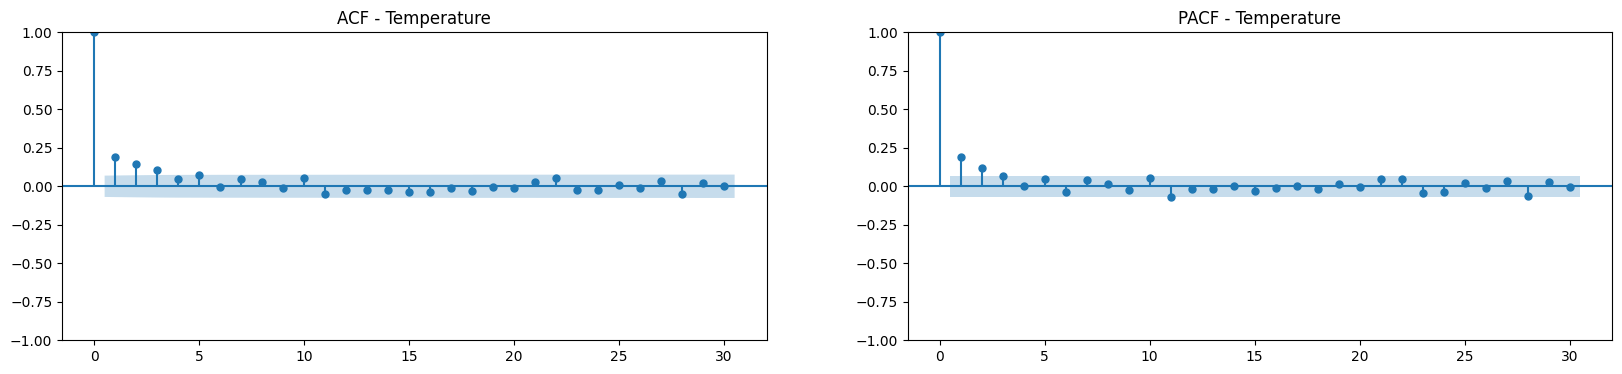

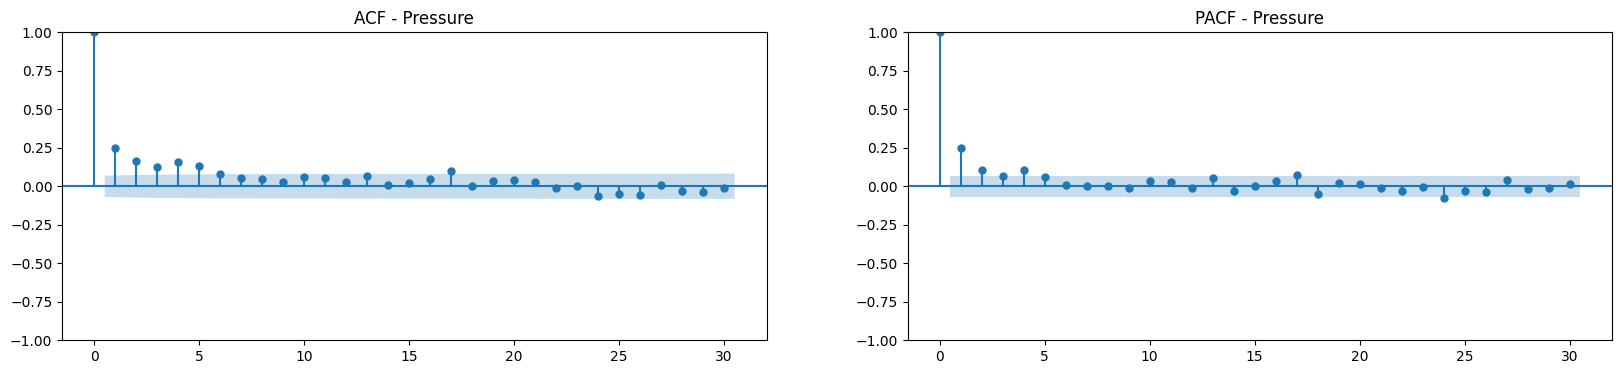

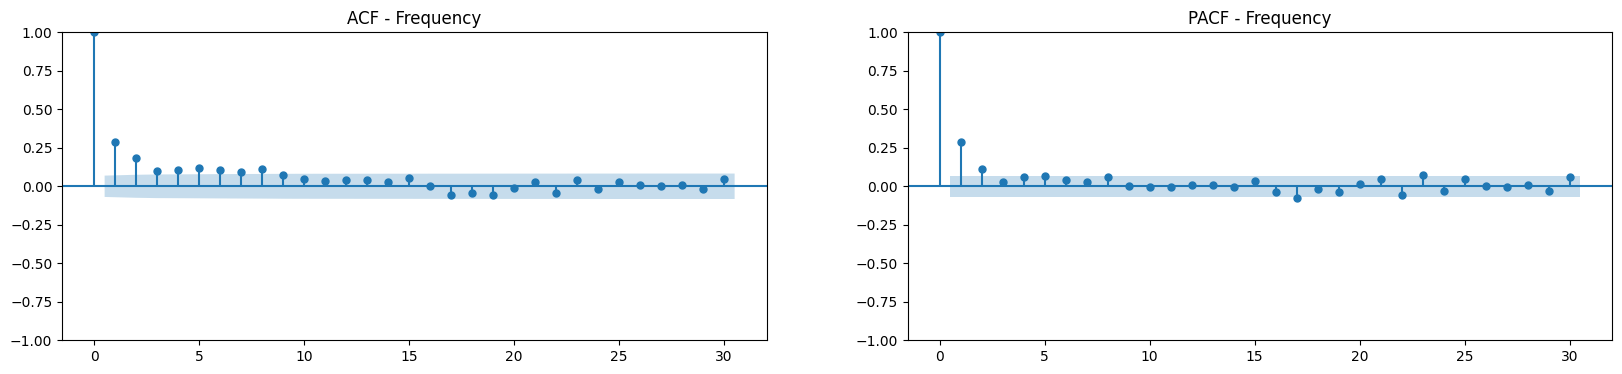

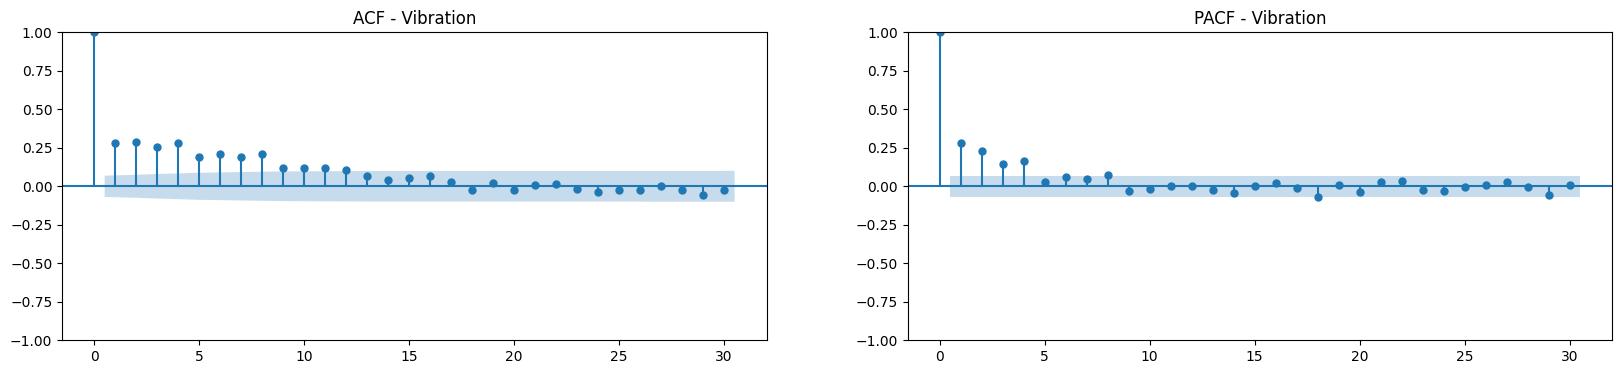

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for col in ['Temperature', 'Pressure', 'Frequency', 'Vibration']:
    series = df[col]
    fig, axes = plt.subplots(1, 2, figsize = (20, 4))
    plot_acf(series, lags = 30, ax = axes[0])
    axes[0].set_title(f'ACF - {col}')
    plot_pacf(series, lags = 30, ax = axes[1])
    axes[1].set_title(f'PACF - {col}')
    plt.show()

The blue zone indicates the region where autocorrelation values are not statistically significant.

Based on the ACF and PACF analysis:
- Temperature shows influence from up to 3 past cycles, with a direct effect up to 2 cycles before.
- Pressure has a longer memory, with influence up to 5 cycles, but only 1 cycle has direct impact.
- Frequency has a stronger memory up to 2 cycles, after that the autocorrelation drops significantly.
- Vibration stands out, showing autocorrelation up to 8 cycles and direct influence from the last 4 cycles.

These results suggest that for predictive modeling, it's valuable to create lag features based on the last 1 to 8 cycles, depending on the variable. With that, **the model should be able to capture early patterns of failure**.

Now I'll calculate the new set of target features:

In [23]:
for i in range(1,9):
    df[f'PreFail_{i}']= df['Fail'].shift(-i).fillna(False)

The next step is to create some features that can give my model a behavioral notion of the readings over the last lags (according to each variable). So, for each variable among Temperature, Pressure, Frequency, and Vibration, I mapped the most important lags and calculated the following features in a window equal to each statistically relevant lag in the ACF:
- the moving average
- the moving standard deviation
- the minimum value
- the maximum value

Right after the initial training, I'll test whether these variable-specific rolling windows actually improve the model's generalization or end up introducing noise. It's generally a good practice to validate if this feature engineering is enhancing model performance.

In [24]:
window_map = {
    'Temperature': 3,
    'Pressure': 5,
    'Frequency': 2,
    'Vibration': 8
}

for var, window in window_map.items():
    df[f'{var}_roll_mean'] = df[var].rolling(window).mean().fillna(df[var].mean())
    df[f'{var}_roll_std'] = df[var].rolling(window).std().fillna(df[var].std())
    df[f'{var}_roll_min'] = df[var].rolling(window).min().fillna(df[var].min())
    df[f'{var}_roll_max'] = df[var].rolling(window).max().fillna(df[var].max())

# Model

For the first attempt at running a model, some decisions were made and I'll briefly explain why they have been made:
- I chose to use **XGBoost** as the classifier because it's robust and efficient. Simpler models like DecisionTreeClassifier often overfit and XGBoost presented better performance than RandomForestClassifier on my tests.
- The dataset is a time-series using cycle as time unit, and, therefore, tecniques like TestTrainSplit or StratifiedKFold would lead to data leakage, compromising the performance of the model on production while giving better results at training than it should have. And **instead of using TimeSeriesSplit, I'll manually split my data** (70% for training and 30% for evaluation), because the amount of failures in the dataset is small and splitting into many folds would harm the model's performance.
- **Recall is the go-to metric** to evaluate the model. In this business case the cost of false negatives is higher than a false positive since missing a failure warning is more critical, leading the equipment straight to failure and triggering an emergency maintenance. This scenario leads to downtime, which I'm trying to avoid.

PreFail_1: F1 = 0.4737 | Recall = 0.4091 | Precision = 0.5625


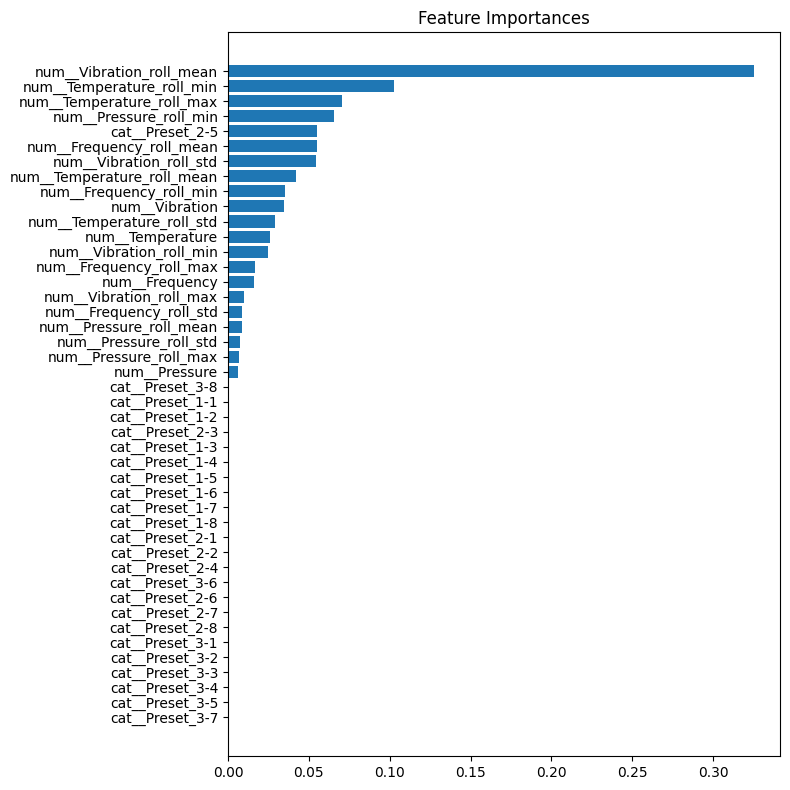

PreFail_2: F1 = 0.2286 | Recall = 0.1818 | Precision = 0.3077
PreFail_3: F1 = 0.2222 | Recall = 0.1818 | Precision = 0.2857
PreFail_4: F1 = 0.1765 | Recall = 0.1364 | Precision = 0.2500
PreFail_5: F1 = 0.2857 | Recall = 0.2273 | Precision = 0.3846
PreFail_6: F1 = 0.0690 | Recall = 0.0455 | Precision = 0.1429
PreFail_7: F1 = 0.0714 | Recall = 0.0455 | Precision = 0.1667
PreFail_8: F1 = 0.0000 | Recall = 0.0000 | Precision = 0.0000


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, fbeta_score, recall_score, precision_score
from xgboost import XGBClassifier
import shap

original_features = ['Temperature', 'Pressure', 'Frequency', 'Vibration']
categorical_features = ['Preset']
calculated_features = [col for col in df.columns if any(key in col for key in ['lag', 'roll', 'diff'])]

x_train = df.iloc[:int(df.shape[0]*0.7),:][original_features+calculated_features+categorical_features]
y_train = df.iloc[:int(df.shape[0]*0.7),:][[col for col in df.columns if any(key in col for key in ['PreFail_'])]]

x_test = df.iloc[int(df.shape[0]*0.7):,:][original_features+calculated_features+categorical_features]
y_test = df.iloc[int(df.shape[0]*0.7):,:][[col for col in df.columns if any(key in col for key in ['PreFail_'])]]

preprocessor_ts = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', original_features+calculated_features)
    ],
    remainder='drop'
)

pipeline_ts = Pipeline([
    ('preprocessor', preprocessor_ts),
    ('classifier', XGBClassifier())
])

def evaluate_ts_model(pipeline, x_train, x_test, y_train, y_test, range):
    """
    Quickly evaluate the model while iterating over the different target features created.

    Parameters:
    - pipeline: The pipeline containing the model.
    - x_train: train data for features
    - x_test: test data for features
    - y_train: train data for target features
    - y_test: train data for target features
    - range: how many target features will be evaluated

    Returns:
    - Print metrics on screen and in case of just one target feature is selected, returns a dataframe containing feature importances.
    """
    for i in range:
        
        # Defining lists that are going to receive the resulting metrics
        recalls = []
        precisions = []
        f1scores = []
        importances = []

        # Fitting the model on the current fold
        model_fold = pipeline.fit(x_train, y_train.iloc[:,i])

        # Getting predicted outcomes for current fold
        outcome = model_fold.predict(x_test)

        # Retrieving feature importances
        model_steps = pipeline.named_steps['classifier']
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
        importance = model_steps.feature_importances_
        importances.append(importance)

        feat_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
            }).sort_values(by='Importance', ascending=False)

        # Calculating performance metrics for current fold
        precision_score_1 = precision_score(y_test.iloc[:,i], outcome)
        recall_score_1 = recall_score(y_test.iloc[:,i], outcome)
        f1_score_1 = f1_score(y_test.iloc[:,i], outcome)

        # Storing metrics into their lists
        precisions.append(precision_score_1)
        recalls.append(recall_score_1)
        f1scores.append(f1_score_1)

        # Output of the obtained metrics
        print(f'PreFail_{i+1}: F1 = {np.mean(f1scores):.4f} | Recall = {np.mean(recalls):.4f} | Precision = {np.mean(precisions):.4f}')

        if i==0:
            plt.figure(figsize=(8, 8))
            plt.barh(feat_importance_df['Feature'][:], feat_importance_df['Importance'][:])
            plt.gca().invert_yaxis()
            plt.title("Feature Importances")
            plt.tight_layout()
            plt.show()
        
        if len(range) == 1:
            return feat_importance_df

evaluate_ts_model(pipeline_ts, x_train, x_test, y_train, y_test, range(0,8))


The first training returned a model with a Recall of 0.4091 while it's noticeable how performance is going down at each PreFail.

I've decided not to plot every Feature Importance do keep it clean since other models were not performing as good as the first one.

## Feature Selection

Now a brief test without the engineered features:

PreFail_1: F1 = 0.6977 | Recall = 0.6818 | Precision = 0.7143


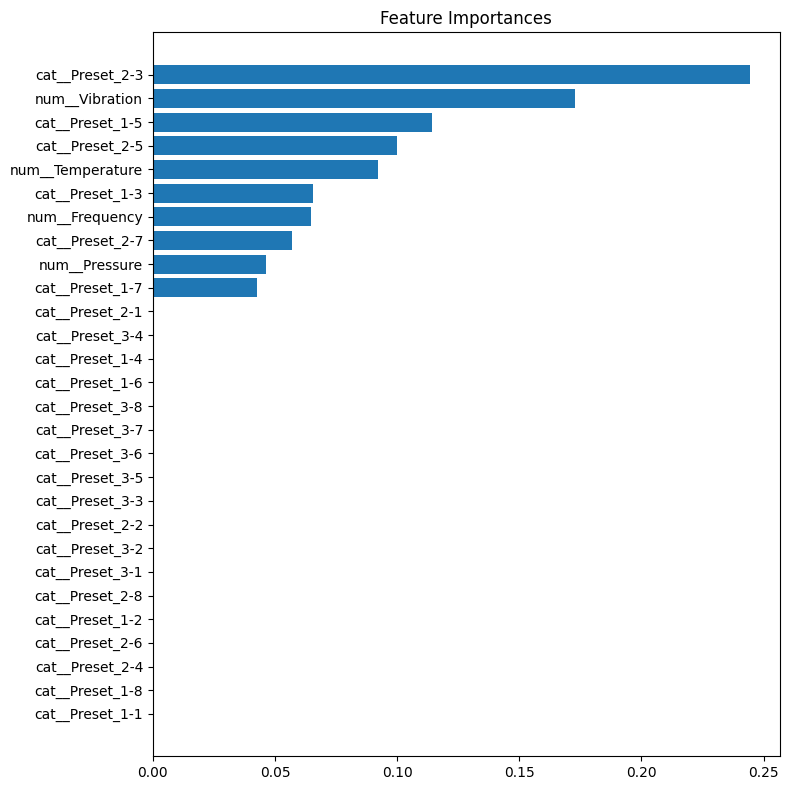

PreFail_2: F1 = 0.4878 | Recall = 0.4545 | Precision = 0.5263
PreFail_3: F1 = 0.5000 | Recall = 0.4545 | Precision = 0.5556
PreFail_4: F1 = 0.5263 | Recall = 0.4545 | Precision = 0.6250
PreFail_5: F1 = 0.4500 | Recall = 0.4091 | Precision = 0.5000
PreFail_6: F1 = 0.4103 | Recall = 0.3636 | Precision = 0.4706
PreFail_7: F1 = 0.2632 | Recall = 0.2273 | Precision = 0.3125
PreFail_8: F1 = 0.2500 | Recall = 0.1818 | Precision = 0.4000


In [26]:
original_features = ['Temperature', 'Pressure', 'Frequency', 'Vibration']
categorical_features = ['Preset']
#calculated_features = [col for col in df.columns if any(key in col for key in ['lag', 'roll', 'diff'])]

x_train_2 = df.iloc[:int(df.shape[0]*0.7),:][original_features+categorical_features]
y_train_2 = df.iloc[:int(df.shape[0]*0.7),:][[col for col in df.columns if any(key in col for key in ['PreFail_'])]]

x_test_2 = df.iloc[int(df.shape[0]*0.7):,:][original_features+categorical_features]
y_test_2 = df.iloc[int(df.shape[0]*0.7):,:][[col for col in df.columns if any(key in col for key in ['PreFail_'])]]

preprocessor_ts_2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', original_features)
    ],
    remainder='drop'
)

pipeline_ts_2 = Pipeline([
    ('preprocessor', preprocessor_ts_2),
    ('classifier', XGBClassifier())
])

evaluate_ts_model(pipeline_ts_2, x_train_2, x_test_2, y_train_2, y_test_2, range(0,8))

The PreFail_1 model already returned a **Recall of 0.6818**, even without the engineered rolling features, suggesting that the base readings already contains enough information for failure detection. This also reinforces that those features, despite being statistically motivated, may not add significant predictive power or might introduce noise instead.

Also, the Feature Importance plot show how a few Presets hold importance while the rest shows no trace of importance to the model, indicating that **only certain presets contribute meaningfully to the prediction**, and the others might be redundant or irrelevant in this context.

I'll check if any of the columns have high correlation in an attempt to reduce model's complexity by removing columns that cause multicollinearity.

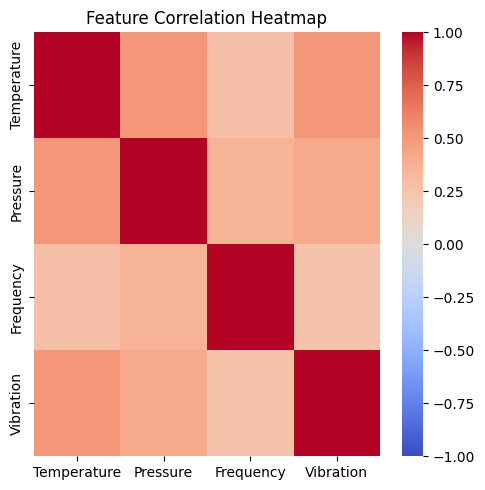

In [27]:
corr_matrix = x_test_2.drop(columns='Preset').corr()

plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [28]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Pairs with high correlation
high_corr = upper.stack().reset_index()
high_corr.columns = ['Feature_1', 'Feature_2', 'Correlation']
high_corr_filtered = high_corr[high_corr['Correlation'].abs() > 0.85]

print(high_corr_filtered.sort_values(by='Correlation', ascending=False))

Empty DataFrame
Columns: [Feature_1, Feature_2, Correlation]
Index: []


Since the dataset does not contains highly correlated features, it's now appropriate to **explore the impact and interpretability of each variable using SHAP** values. This will allow for a clearer understanding of how individual features contribute to the model's predictions, without redundancy distorting the insights.

For the simplicity of this business case, **I'll focus on PreFail_1 model.**

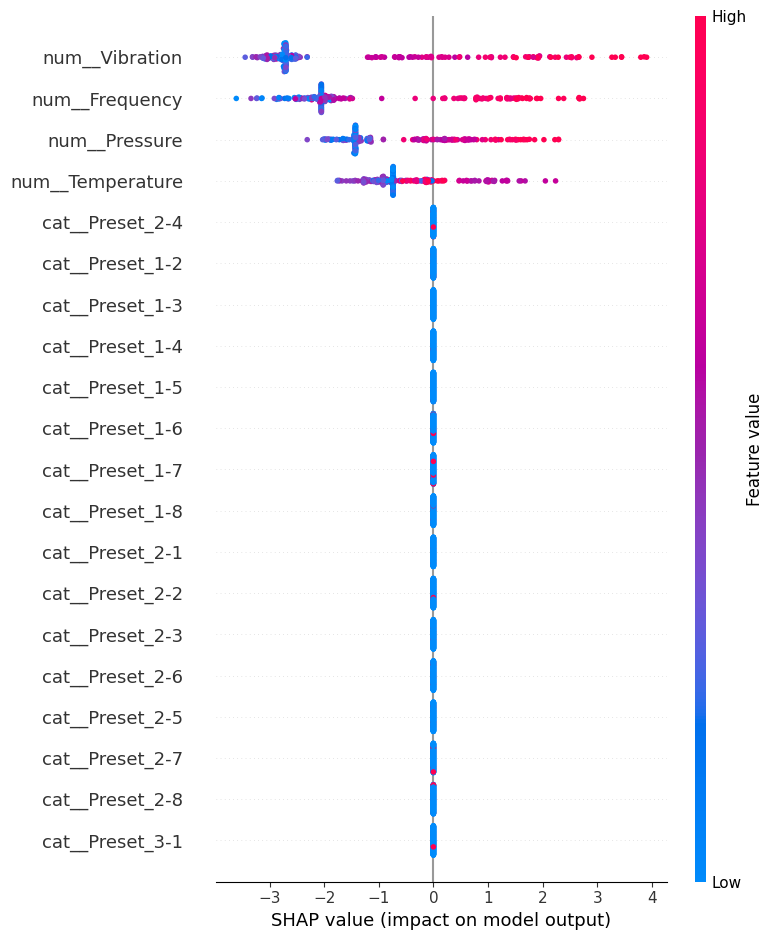

In [29]:
def shap_analysis(x, y):
    """
    Plots SHAP's summary plot.

    Parameters:
    - x: features
    - y: target feature
    
    Returns:
    - Print SHAP's summary plot, also returns a dataframe containing SHAP's feature importances.
    """
    # Creating a new model to simplify
    shap_model = XGBClassifier(random_state=10)
    shap_model.fit(x, y)

    explainer = shap.Explainer(shap_model)
    shap_values = explainer(x)
    shap.summary_plot(shap_values, x)

    mean_shap_values = np.abs(shap_values.values).mean(axis=0)
    shap_importance = pd.DataFrame({
        'Feature': x.columns,
        'Importance': mean_shap_values
    }).sort_values(by='Importance', ascending=False)

    return shap_importance

x_test_2_preprocessed = preprocessor_ts_2.transform(x_test_2)
feature_names = preprocessor_ts_2.get_feature_names_out()

x_test_2_shap = pd.DataFrame(x_test_2_preprocessed.toarray(), columns=feature_names)

shap_analysis_2 = shap_analysis(x_test_2_shap, y_test.iloc[:,0])

This summary plot from SHAP shows the distribuition of each feature along an "impact axis" and if a feature is "clumped" around the 0 mark, it means the model is relatively **insensitive** to variations in that feature. In other words, **it has low predictive power or minimal influence on the model's output.**

If the high feature values are well separated by the 0 mark from the low feature values, it means that feature has a strong impact on the model's predictions, that is, its value pushes the prediction closer to *failure* or *'no failure'*, depending on its magnitude. A low amplitude could mean low magnitude.

The SHAP impact on model shows almost no impact for each category of Preset, which is expected since each Preset category is "activated" just for a small sample of the dataset, also, SHAP calculates the average importance of each categorical variable, not the group, specially if it's encoded using OneHot. **This does not means that Preset as a whole is not impactful on model's prediction.**

Just to experiment, I'll check if removing Preset has a positive or negative impact at model metrics, having in mind that just a few presets had values in the Feature Importance plot.

In [30]:
original_features = ['Temperature', 'Pressure', 'Frequency', 'Vibration']
# categorical_features = ['Preset']
#calculated_features = [col for col in df.columns if any(key in col for key in ['lag', 'roll', 'diff'])]

x_train_3 = df.iloc[:int(df.shape[0]*0.7),:][original_features]
y_train_3 = df.iloc[:int(df.shape[0]*0.7),:][[col for col in df.columns if any(key in col for key in ['PreFail_'])]]

x_test_3 = df.iloc[int(df.shape[0]*0.7):,:][original_features]
y_test_3 = df.iloc[int(df.shape[0]*0.7):,:][[col for col in df.columns if any(key in col for key in ['PreFail_'])]]

preprocessor_ts_8 = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', original_features)
    ],
    remainder='drop'
)

pipeline_ts_3 = Pipeline([
    ('classifier', XGBClassifier())
])

# Defining lists that are going to receive the resulting metrics
recalls = []
precisions = []
f1scores = []
importances = []

# Fitting the model on the current fold
model_fold = pipeline_ts_3.fit(x_train_3, y_train_3.iloc[:,0])

# Getting predicted outcomes for current fold
outcome = model_fold.predict(x_test_3)

# Retrieving feature importances
model_steps = pipeline_ts_3.named_steps['classifier']
feature_names = x_train_3.columns
importance = model_steps.feature_importances_
importances.append(importance)

# Calculating performance metrics for current fold
precision_score_1 = precision_score(y_test_3.iloc[:,0], outcome)
recall_score_1 = recall_score(y_test_3.iloc[:,0], outcome)
f1_score_1 = f1_score(y_test_3.iloc[:,0], outcome)

# Storing metrics into their lists
precisions.append(precision_score_1)
recalls.append(recall_score_1)
f1scores.append(f1_score_1)

# Output of the obtained metrics
print(f'PreFail_1: F1 = {np.mean(f1scores):.4f} | Recall = {np.mean(recalls):.4f} | Precision = {np.mean(precisions):.4f}')


PreFail_1: F1 = 0.6341 | Recall = 0.5909 | Precision = 0.6842


As expected, the Recall lowered significantly. 

The second model version is simple enough, features wise, and is performing at an acceptable level.

## Fine Tuning

The second model's version presented a 0.6818 for Recall and 0.7143 for Precision. A Hyperparameter optmization with **Randomized Search CV** could boost metrics a little bit to improve model's performance. Keeping in mind that for this business case, **it's important to have the higher recall as possible while still maintaining a good precision** to avoid letting the equipment fail without predicting it.

So Randomized Search CV will use a custom metric in order to tune the model. This metric is called F-beta and it gives a weight to precision or recall depending on it's value:
- beta = 1 works just like F1 score
- beta < 1 prioritizes Precision
- beta > 1 prioritizes Recall

I'll start with beta = 2

In [31]:
param_dist = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 4, 5, 6, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__scale_pos_weight': [1, 3, 5, 7, 9, 11]
}

custom_score = make_scorer(fbeta_score, beta=2)

print("\nRunning RandomizedSearchCV")

# Define model pipeline
pipeline_ts_2 = Pipeline([
    ('preprocessor', preprocessor_ts_2),
    ('classifier', XGBClassifier(random_state=10, use_label_encoder=False, eval_metric='logloss'))
])

# Randomized Search
search = RandomizedSearchCV(
    estimator=pipeline_ts_2,
    param_distributions=param_dist,
    n_iter=20,
    scoring=custom_score,
    verbose=1,
    n_jobs=-1,
    random_state=10
)

# Fit model
search.fit(x_train_2, y_train_2.iloc[:,0]) # Fitting with train to avoid data-leakage

# Evaluate on test set
y_pred_test = search.best_estimator_.predict(x_test_2)
test_fbeta = fbeta_score(y_test_2.iloc[:, 0], y_pred_test, beta=2)

print(f"F-beta on test set: {test_fbeta:.4f}")
print(f"Best params: {search.best_params_}")


Running RandomizedSearchCV
Fitting 5 folds for each of 20 candidates, totalling 100 fits
F-beta on test set: 0.7308
Best params: {'classifier__subsample': 1.0, 'classifier__scale_pos_weight': 11, 'classifier__n_estimators': 50, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01, 'classifier__colsample_bytree': 0.8}


The RandomSearchCV is being used only to search for hyperparameters, avoiding the use of the *best_score* metric, because that would return me a value based on cross validation, which would have data leakage.

This way, the final evaluation is being calculated on the test dataset to bring the F-beta score based on data the model has never seen before, which is fine!

The best parameters for the model with the following values:
- subsample=1.0
- scale_pos_weight=11
- n_estimators=50
- max_depth=3
- learning_rate=0.01
- colsample_bytree=0.8

In [32]:
original_features = ['Temperature', 'Pressure', 'Frequency', 'Vibration']
categorical_features = ['Preset']
#calculated_features = [col for col in df.columns if any(key in col for key in ['lag', 'roll', 'diff'])]

x_train_2 = df.iloc[:int(df.shape[0]*0.7),:][original_features+categorical_features]
y_train_2 = df.iloc[:int(df.shape[0]*0.7),:][['PreFail_1']]

x_test_2 = df.iloc[int(df.shape[0]*0.7):,:][original_features+categorical_features]
y_test_2 = df.iloc[int(df.shape[0]*0.7):,:][['PreFail_1']]

preprocessor_ts_2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', original_features)
    ],
    remainder='drop'
)

pipeline_ts_2 = Pipeline([
    ('preprocessor', preprocessor_ts_2),
    ('classifier', XGBClassifier(random_state=10,
                                 subsample=1.0,
                                 scale_pos_weight=11,
                                 n_estimators=50,
                                 max_depth=3, 
                                 learning_rate=0.01, 
                                 colsample_bytree=0.8
                                 ))
])

def evaluate_final_model(pipeline, x_train, x_test, y_train, y_test):
    """
    Quickly evaluate the model.

    Parameters:
    - pipeline: The pipeline containing the model.
    - x_train: train data for features
    - x_test: test data for features
    - y_train: train data for target features
    - y_test: train data for target features

    Returns:
    - Print metrics on screen and returns a dictionary with F1, Recall and Precision scores.
    """
    pipeline.fit(x_train, y_train)  # Fit on training data
    
    # Predict on test set
    y_pred_test = pipeline.predict(x_test)
    
    # Calculate metrics
    recall = recall_score(y_test, y_pred_test, zero_division=0)
    precision = precision_score(y_test, y_pred_test, zero_division=0)
    f1 = f1_score(y_test.iloc[:, 0], y_pred_test, zero_division=0)
    
    # Print results
    print(f'Test Metrics: F1 = {f1:.4f} | Recall = {recall:.4f} | Precision = {precision:.4f}')

    return {'recall': recall, 'precision': precision, 'f1': f1}

# Evaluate the model
results = evaluate_final_model(pipeline_ts_2, x_train_2, x_test_2, y_train_2, y_test_2)

Test Metrics: F1 = 0.5938 | Recall = 0.8636 | Precision = 0.4524


The current model achieves the following metrics on the test set:

- **F1 Score:** 0.5938
- **Recall:** 0.8636
- **Precision:** 0.4524

While the recall is strong, indicating the model effectively identifies most failures, the precision is relatively low, leading to a moderate F1 score. For our business case, high recall is critical to minimize missed failures, even at the cost of some precision.

A threshold tuning would be an option to balance the trade-off between Precision and Recall, but since Recall is the most important metric, I'll leave the balance at this scenario and plot how the model is predicting failures against real failures.

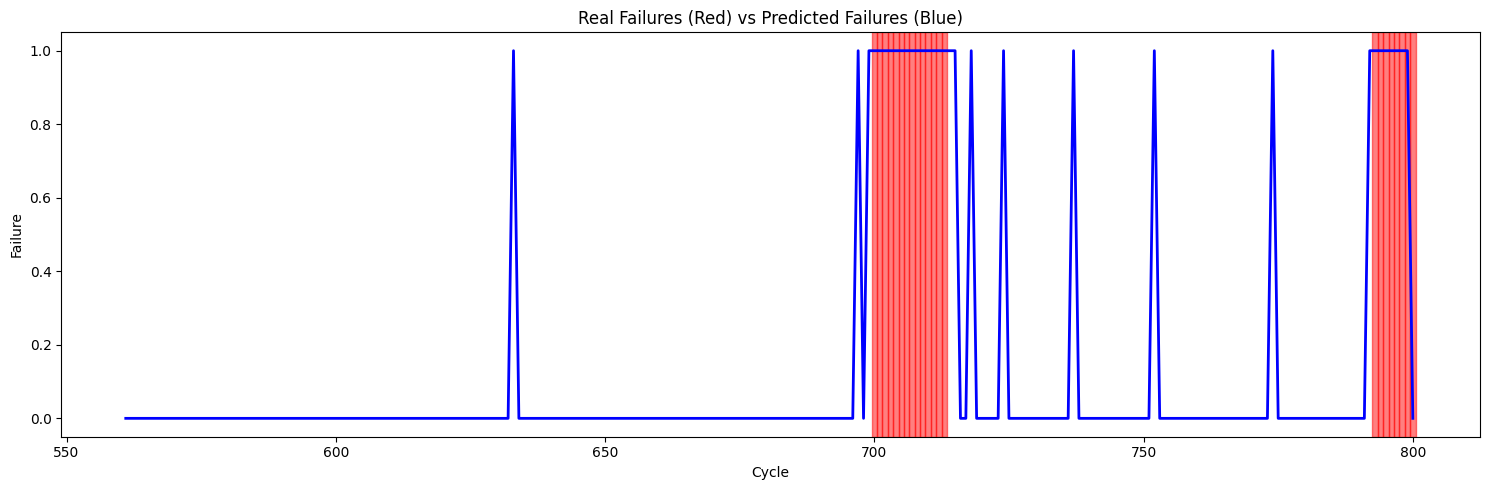

In [33]:
cycles = df.iloc[int(df.shape[0]*0.7):,:]['Cycle'].values
real_fail = df.iloc[int(df.shape[0]*0.7):,:]['Fail'].values

# 2. Gere as previsões do modelo
y_proba = pipeline_ts_2.fit(x_test_2, y_test_2.values.ravel()).predict_proba(x_test_2)[:,1]
threshold = 0.5
fail_pred = (y_proba >= threshold).astype(int)

real_fail_cycles = cycles[real_fail == 1]
pred_fail_cycles = cycles[fail_pred == 1]

plt.figure(figsize=(15, 5))
# Failures predicted by the model in a blue line
plt.plot(cycles, fail_pred, label='Predicted Failures', color='blue', linewidth=2)

# Real failures as a red span
for c in real_fail_cycles:
    plt.axvspan(c - 0.5, c + 0.5, color='red', alpha=0.5)

plt.title('Real Failures (Red) vs Predicted Failures (Blue)')
plt.xlabel('Cycle')
plt.ylabel('Failure')
plt.tight_layout()
plt.show()


The model is able to predict the incoming failure before it happens, as evidenced by the blue predicted failure spikes aligning with or slightly preceding the red spans of real failures. 

A key strength of the model is its high recall, ensuring that potential failures are rarely missed, which is critical for avoiding an emergency mainteance that leads to downtime. This proactive approach results in a higher number of predicted alarms, including some moments where equipment is not actually failing. This reflects the model’s low precision, leading to additional alerts.

## Conclusion

The model shows strong overall performance, with a macro average F1-score of 0.89, indicating good balance between precision and recall across both classes.

For the positive class (the critical class in the business case), it was achieved:

- **Recall of 0.8636**: meaning the model successfully identifies 86% of the actual positives.
- **Precision of 0.4524**: meaning 45% of the predicted positives are truly positive.
- **F1 Score of 0.5938**: still represents a solid balance given the emphasis on recall

This result aligns well with the business objective of prioritizing high recall. The number of features was kept at a small size, being a **parsimonious** model rather than a complex one.

The model needs further tuning, a bigger dataset would help tecniques like TimeSeriesSplit. Additionally, finding new features with time-series specific indicators could help enhancing precision while preserving the high recall, letting the model predict at operational needs.


## Next Steps

Better results could be achieved through many ways, being a few of them:
- Running a LSTM model to capture long-term dependencies and temporal patterns in the time-series data.
- Expanding the dataset with additional historical data to improve model generalization and enabling techniques like TimeSeriesSplit
- Advanced feature engineering, to better detect early failure signals